### Shock Cooling Emission (SCE) Type IIb Supernova Metric Implementation

The `ShockCoolingType2b` suite of metrics explores how well LSST can detect and characterize **shock-cooling emission peaks** in Type IIb supernovae, with particular attention to identifying **double-peaked light curves**. These peaks reflect an early, short-lived shock-cooling flash followed by the longer, radioactive-powered peak.

The light curve starts with an immediate rise toward the shock-cooling peak—there's no flat, constant-brightness phase before it. This mirrors real Type IIb SNe like ZTF18aalrxas and SN 2021vgn, which show rapid early brightening without a visible pre-flash plateau. 

### 1. Light Curve Modeling

**Class:** `ShockCoolingLC`

- Simulates synthetic light curves in **g** and **r** bands.
- Models four key phases:
  - **Initial rise** to the shock-cooling peak,
  - **Short plateau** (duration at peak),
  - **Fade** after the peak,
  - **Re-rise** to the nickel-powered second peak.
- Parameters (rise/fade rates, magnitudes) are drawn from distributions based on real SNe IIb (e.g., ZTF18aalrxas, SN 2021vgn).
- Each light curve template represents a different realization of plausible SCE behavior.

### 2. Detection Criteria

**Function:** `evaluate_sce()`

- An event is **detected** if:
  - There are **≥2 observations in the same filter**,
  - Each is detected at **≥5σ**, and
  - The observations are **≥0.5 days apart**.
  
This aims to reject false positives (e.g., noise or fast-moving solar system objects).

### 3. Characterization Criteria

**Function:** `characterize_sce()`

Classifies how well each light curve is sampled in time:

- **Classical**: ≥2 observations with SNR ≥0.5 in **each phase**:
  - Rise (−3 to 0 days),
  - Fade (0 to 7 days),
  - Re-rise (7 to 13 days).
- **Ambiguous**: ≥6 observations with SNR ≥0.5 but not spread across all three phases.
- **Uncharacterized**: <6 total detections with SNR ≥0.5.

This phase-based scheme ensures we can interpret the transient structure, not just detect it.

### 4. Double-Peak Identification

- A **second peak** is flagged if:
  - There are ≥2 observations between **7 and 13 days** post-peak,
  - Each has SNR ≥0.5.

This helps identify SNe IIb with strong shock-cooling and radioactive components.

### 5. Population Generation Based on Volumetric Rate

**Function:** `generateShockCoolingType2bSlicer()`

**Questions here regarding population

- Volumetric rate basis:
  - ~10–11% of CCSNe are Type IIb.
  - Rubin is expected to detect ~1 million SNe/year → ~65,000 SNe IIb/year.
- Over 10 years: **~650,000 synthetic events**.

Each synthetic event includes:

- RA/Dec (uniform sphere),
- Distance (10–300 Mpc),
- Explosion time (days 1–3652),
- One of 100 synthetic light curve templates (`file_indx`),
- Extinction value `E(B–V)` from `SFDQuery()`.

### 6. Dust Extinction Correction

- Line-of-sight extinction queried from SFD dust maps.
- Extinction applied using `ax1` values from `DustValues()` for each band.

### 7. Metric Subclasses

Each metric subclass evaluates a specific detection or classification condition:

- `ShockCoolingType2bDetectMetric`: Did this event meet the detection threshold?
- `ShockCoolingType2bCharacterizeMetric`: Was this event **fully characterized** (i.e., classical)?
- `ShockCoolingType2bClassicalMetric`: Specifically flags **classical** events.
- `ShockCoolingType2bAmbiguousMetric`: Event is **ambiguous** (not fully phase-sampled).
- `ShockCoolingType2bUncharacterizedMetric`: Event is **undersampled** (<6 SNR ≥0.5).
- `ShockCoolingType2bDoublePeakMetric`: Event shows a **second peak** in light curve.

### 8. Sky Map Plotting and Output Files

- Metrics grouped and visualized using `MetricBundleGroup` and `HealpixSkyMap`.
- Results saved in:
  - `efficiency_<cadence>_shockcooling.csv`: Summary efficiency stats.
  - `type2b_phases_<cadence>_shockcooling.csv`: Per-event classification results.

### 9. How the Code Works Step-by-Step

1. **Generate Population**:
   - `generateShockCoolingType2bSlicer()` simulates ~650,000 events across the sky with distance, explosion time, extinction, and template index.

2. **Assign Light Curves**:
   - Each event is assigned a synthetic light curve based on randomized SCE parameters.

3. **Extract Observations**:
   - The metric evaluates LSST observations (`dataSlice`) within the region and time window of each event.

4. **Compute Apparent Magnitudes**:
   - For each observation, interpolate the light curve and apply extinction.

5. **Calculate SNR and Apply Criteria**:
   - Use `m52snr()` to calculate SNR from magnitude and 5σ depth.
   - Check detection and characterization conditions.

6. **Save Results and Plot**:
   - Metrics are stored per event and used to generate efficiency CSVs and sky map visualizations.

### 10. Design Philosophy and Rationale

- **Population size** reflects expected SNe IIb rates.
- **Detection logic** is simple and avoids transient confusion.
- **Phase-based classification** helps ensure we understand the structure of the light curve.
- **Double-peak detection** enables testing early-time science capabilities.
- **Consistent extinction treatment** makes the metric robust and compatible with Rubin tools.

### 11. Example: Classical Event

A synthetic SN IIb in the g-band might be observed:

At day −2 and +0.5 with SNR >5 → Detected.

At day −2, +0.5, +3, +5, +8, and +11 with SNR >0.5 → Classical.

Two of those detections fall between day +7 and +13 → Double peak flagged.

This meets all conditions for detection, characterization, and double-peak tagging.




In [237]:
%matplotlib inline

import glob
import os
import random
import json
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
from rubin_sim.maf.metrics import CountMetric
from local_opsdb_patch import OpsimDatabase #local
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots
from rubin_sim.maf.slicers import HealpixSlicer
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from rubin_sim.maf.metric_bundles import MetricBundleGroup
from rubin_sim.maf.metric_bundles import MetricBundle
from rubin_sim.maf.metrics import MeanMetric


from rubin_sim.maf.maps import StellarDensityMap

#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
import astropy.units as u
import healpy as hp

from rubin_sim.phot_utils import DustValues

dust_model = DustValues()


def equatorialFromGalactic(lon, lat):
    gal = Galactic(l=lon * u.deg, b=lat * u.deg)
    equ = gal.transform_to(ICRS)
    return equ.ra.deg, equ.dec.deg

def hpid2RaDec(nside, hpidx):
    theta, phi = hp.pix2ang(nside, hpidx, nest=False)
    ra = np.degrees(phi)
    dec = 90.0 - np.degrees(theta)
    return ra, dec

def healbin(lon, lat, nside=64, nest=False):
    theta = np.radians(90. - lat)
    phi = np.radians(lon)
    return hp.ang2pix(nside, theta, phi, nest=nest)

_healbin = healbin

#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [257]:
##RUN TWICE

import sys
import importlib

if "local_ShockCoolingType2b" in sys.modules:
    del sys.modules["local_ShockCoolingType2b"]
import local_ShockCoolingType2b
importlib.reload(local_ShockCoolingType2b)

from local_ShockCoolingType2b import (
    ShockCoolingLC,
    ShockCoolingType2bDetectMetric,
    ShockCoolingType2bCharacterizeMetric,
    ShockCoolingType2bClassicalMetric,
    ShockCoolingType2bAmbiguousMetric,
    ShockCoolingType2bUncharacterizedMetric,
    ShockCoolingType2bDoublePeakMetric,
    generateShockCoolingType2bSlicer,
    uniform_wfd_sky
)
print(local_ShockCoolingType2b.__file__)

/Users/andradenebula/Documents/Research/Transient_Metrics/Stuff/AllTransient/local_ShockCoolingType2b.py


In [253]:
# --- Configuration ---
dmin, dmax = 10, 300
rate_per_year = 65000
gal_lat_cut = 15
cadence_nickname = 'four_roll_v4.3.1_10yrs'

outfile = f"AllTransient_MetricDetection/local_efficiency_{cadence_nickname}_shockcooling.csv"
typefile = f"AllTransient_MetricDetection/Types_csv/type2b_phases_{cadence_nickname}_shockcooling.csv"
pop_file = "ShockCooling_population.pkl"

# --- Build LSST-like footprint ---
nside = 64
hpx_slicer = HealpixSlicer(nside=nside)
stellar_map = StellarDensityMap()
metric = CountMetric(col='night')

bundle = MetricBundle(metric, hpx_slicer, constraint='', plot_dict={})
bundle.metric.maps = [stellar_map]

bdict = {'stellar_density': bundle}
results_db = ResultsDb(out_dir='temp')  # Separate results db for this setup
bgroup = MetricBundleGroup(bdict, db_con=opsdb, out_dir='temp', results_db=results_db)
bgroup.run_all()

footprint_map = bdict['stellar_density'].metric_values
footprint_map = np.nan_to_num(footprint_map, nan=0.0)
footprint_map = np.clip(footprint_map, 0, None)  # force negatives to zero

# Ensure safe normalization
total = np.sum(footprint_map)
if not np.isfinite(total) or total <= 0:
    raise ValueError("Footprint map has invalid total weight (<= 0 or non-finite).")

prob_map = footprint_map / total

# Final check (can be removed after debugging)
assert np.isclose(np.sum(prob_map), 1.0, rtol=1e-10), "prob_map does not sum to 1"

# --- Generate or Load Population ---
if os.path.exists(pop_file):
    slicer = generateShockCoolingType2bSlicer(load_from=pop_file)
else:
    slicer = generateShockCoolingType2bSlicer(prob_map=prob_map,
                                              nside=nside,
                                              t_start=1, t_end=3652,
                                              d_min=dmin, d_max=dmax,
                                              gal_lat_cut=gal_lat_cut,
                                              seed=42,
                                              save_to=pop_file)


n_events = len(slicer.slice_points['distance'])

runName = cadence_nickname
opsdb = f"../AllTransient/{runName}.db"
if not os.path.exists(opsdb):
    raise FileNotFoundError(f"Cadence database not found: {opsdb}")

outDir = "AllTransient_MetricDetection/Metric_temp"
resultsDb = db.ResultsDb(out_dir=outDir)

# --- Define Metrics ---
metric_detect = ShockCoolingType2bDetectMetric(metricName="ShockCooling_Detect")
metric_char = ShockCoolingType2bCharacterizeMetric(metricName="ShockCooling_Characterize")
metric_classical = ShockCoolingType2bClassicalMetric(metricName="ShockCooling_Classical")
metric_ambiguous = ShockCoolingType2bAmbiguousMetric(metricName="ShockCooling_Ambiguous")
metric_unchar = ShockCoolingType2bUncharacterizedMetric(metricName="ShockCooling_Uncharacterized")
metric_doublepeak = ShockCoolingType2bDoublePeakMetric(metricName="ShockCooling_DoublePeak")

plotFuncs = [HealpixSkyMap()]
summaryMetrics = [MeanMetric(mask_val=0)]

plotDicts = {
    "ShockCooling_Detect": {"nside": 64, "title": f"{runName} : Detected SCE Events"},
    "ShockCooling_Characterize": {"nside": 64, "title": f"{runName} : Characterized SCE Events"},
    "ShockCooling_Classical": {"nside": 64, "title": f"{runName} : Classical SCE Profile"},
    "ShockCooling_Ambiguous": {"nside": 64, "title": f"{runName} : Ambiguous SCE Profile"},
    "ShockCooling_Uncharacterized": {"nside": 64, "title": f"{runName} : Uncharacterized SCE Profile"},
    "ShockCooling_DoublePeak": {"nside": 64, "title": f"{runName} : Double-Peaked Light Curves"}
}

bdict = OrderedDict({
    "ShockCooling_Detect": MetricBundle(metric_detect, slicer, constraint='', plot_dict=plotDicts["ShockCooling_Detect"], plot_funcs=plotFuncs, summary_metrics=summaryMetrics, file_root=f"{runName}_ShockCooling_Detect"),
    "ShockCooling_Characterize": MetricBundle(metric_char, slicer, constraint='', plot_dict=plotDicts["ShockCooling_Characterize"], plot_funcs=plotFuncs, summary_metrics=summaryMetrics, file_root=f"{runName}_ShockCooling_Characterize"),
    "ShockCooling_Classical": MetricBundle(metric_classical, slicer, constraint='', plot_dict=plotDicts["ShockCooling_Classical"], plot_funcs=plotFuncs, summary_metrics=summaryMetrics, file_root=f"{runName}_ShockCooling_Classical"),
    "ShockCooling_Ambiguous": MetricBundle(metric_ambiguous, slicer, constraint='', plot_dict=plotDicts["ShockCooling_Ambiguous"], plot_funcs=plotFuncs, summary_metrics=summaryMetrics, file_root=f"{runName}_ShockCooling_Ambiguous"),
    "ShockCooling_Uncharacterized": MetricBundle(metric_unchar, slicer, constraint='', plot_dict=plotDicts["ShockCooling_Uncharacterized"], plot_funcs=plotFuncs, summary_metrics=summaryMetrics, file_root=f"{runName}_ShockCooling_Uncharacterized"),
    "ShockCooling_DoublePeak": MetricBundle(metric_doublepeak, slicer, constraint='', plot_dict=plotDicts["ShockCooling_DoublePeak"], plot_funcs=plotFuncs, summary_metrics=summaryMetrics, file_root=f"{runName}_ShockCooling_DoublePeak")
})

print("Running metric bundles...")
bgroup = MetricBundleGroup(bdict, opsdb, out_dir=outDir, results_db=resultsDb)
bgroup.run_all()
bgroup.plot_all(closefigs=True)

with open(outfile, "w") as out:
    out.write("dist_min_Mpc, dist_max_Mpc, metric, found, total, efficiency\\n")
    detected = np.sum(bdict["ShockCooling_Detect"].metric_values == 1)
    for key in bdict:
        val = bdict[key].metric_values
        mask = ~val.mask if hasattr(val, 'mask') else np.ones_like(val, dtype=bool)
        if key != "ShockCooling_Detect":
            found = np.sum((val == 1) & (bdict["ShockCooling_Detect"].metric_values == 1) & mask)
            total = detected
        else:
            found = np.sum((val == 1) & mask)
            total = n_events
        efficiency = found / total if total > 0 else 0
        out.write(f"{dmin}, {dmax}, {key}, {found}, {total}, {efficiency:.4f}\\n")

with open(typefile, "w") as out:
    out.write("index,detected,characterized,classical,ambiguous,uncharacterized,doublepeak\\n")
    for i in range(n_events):
        get_val = lambda k: int(bdict[k].metric_values[i] == 1) if not bdict[k].metric_values.mask[i] else 0
        d = get_val("ShockCooling_Detect")
        c = cl = am = uc = dp = 0
        if d:
            c = get_val("ShockCooling_Characterize")
            cl = get_val("ShockCooling_Classical")
            am = get_val("ShockCooling_Ambiguous")
            uc = get_val("ShockCooling_Uncharacterized")
            dp = get_val("ShockCooling_DoublePeak")
            if uc: cl, am = 0, 0
            elif am: cl = 0
        out.write(f"{i},{d},{c},{cl},{am},{uc},{dp}\\n")

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Generating 649733 SN IIb events from rate: 65000/yr × 10.00 yr
Saved Shock Cooling population to ShockCooling_population.pkl
Saved synthetic SCE light curve templates to ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
Running metric bundles...


/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metric_bundles/metric_bundle_group.py:723: UserWarning: Plotting failed for metricBundle four_roll_v4.3.1_10yrs_ShockCooling_Detect. Error message: THETA is out of range [0,pi]
  warnings.warn(message)
/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metric_bundles/metric_bundle_group.py:723: UserWarning: Plotting failed for metricBundle four_roll_v4.3.1_10yrs_ShockCooling_Characterize. Error message: THETA is out of range [0,pi]
  warnings.warn(message)
/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metric_bundles/metric_bundle_group.py:723: UserWarning: Plotting failed for metricBundle four_roll_v4.3.1_10yrs_ShockCooling_Classical. Error message: THETA 

Plotting: ShockCooling_Detect


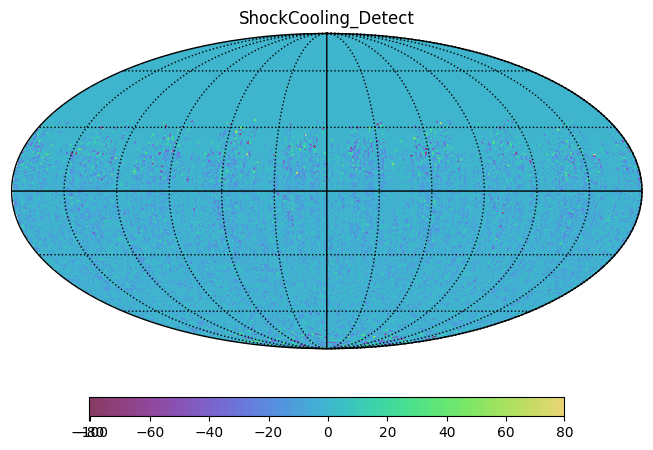

Plotting: ShockCooling_Characterize


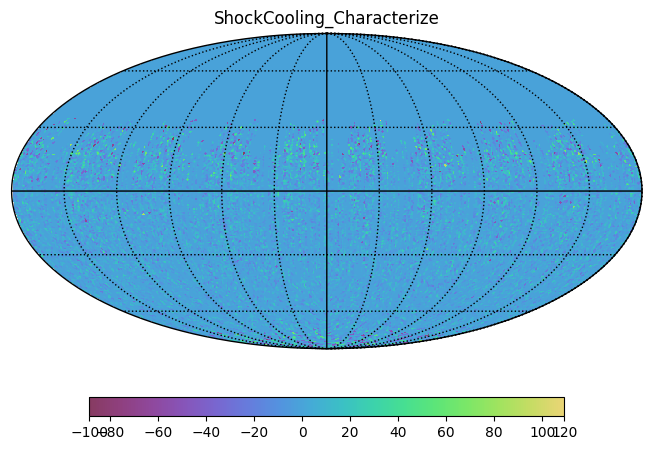

Plotting: ShockCooling_Classical


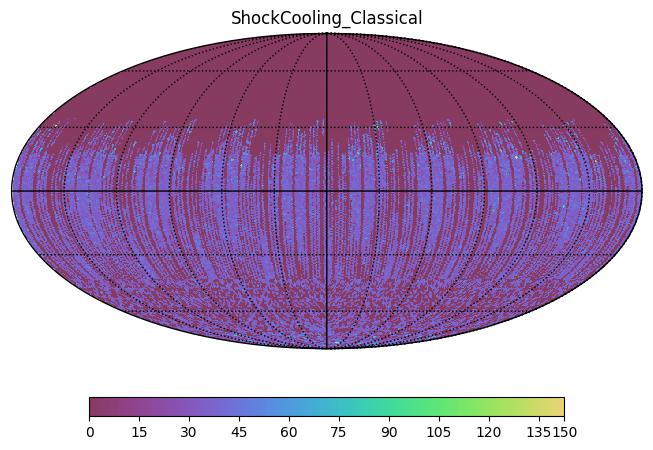

Plotting: ShockCooling_Ambiguous


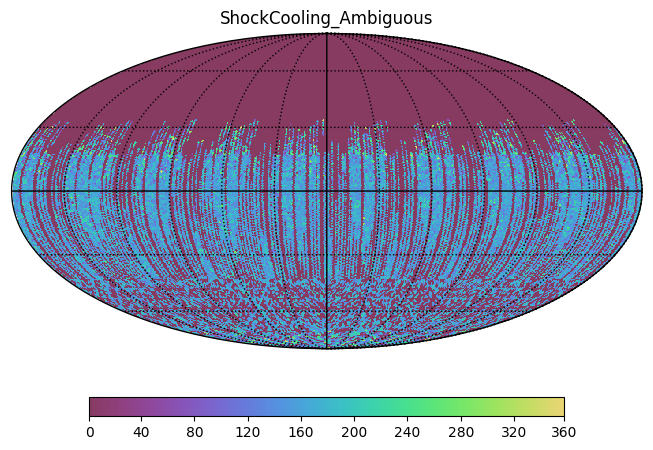

Plotting: ShockCooling_Uncharacterized


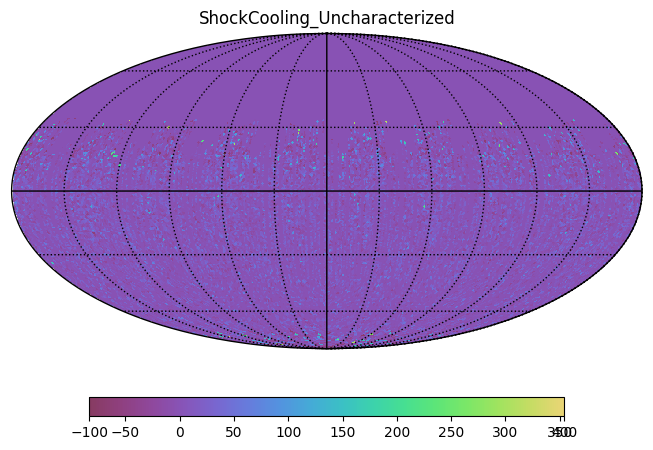

Plotting: ShockCooling_DoublePeak


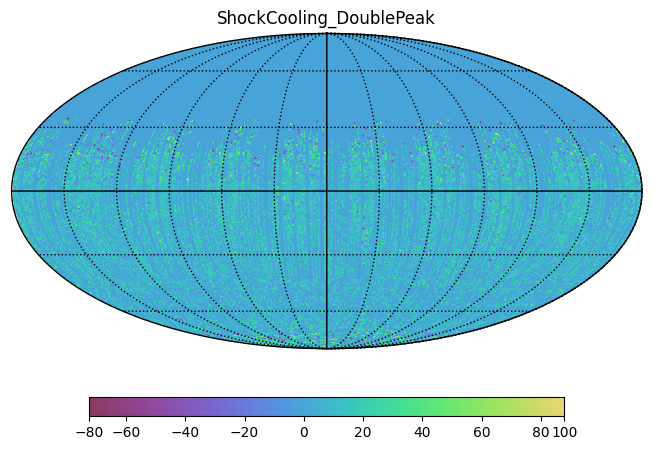

In [254]:
from rubin_sim.maf.plots import HealpixSkyMap
import healpy as hp

plotter = HealpixSkyMap()

for key, bundle in bdict.items():
    if isinstance(bundle.metric_values, np.ma.MaskedArray) and np.issubdtype(bundle.metric_values.dtype, np.number):
        print(f"Plotting: {key}")

        # Convert dec to radians for plotting, but store it temporarily
        ra = bundle.slicer.slice_points['ra']
        dec_deg = bundle.slicer.slice_points['dec']
        dec_rad = np.radians(dec_deg)

        # Temporarily patch in radians to avoid modifying your slicer permanently
        original_dec = bundle.slicer.slice_points['dec']
        bundle.slicer.slice_points['dec'] = dec_rad

        try:
            plotter(bundle.metric_values, slicer=bundle.slicer, user_plot_dict=bundle.plot_dict)
            plt.title(key)
            plt.show()
        finally:
            # Restore the original dec in degrees
            bundle.slicer.slice_points['dec'] = original_dec
    else:
        print(f"Skipping: {key} — metric values not numeric.")
